1. manse_tool_agent
2. retriever_tool_agent
3. 일반 답변에 대한 web search

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Enhanced Retriever 및 Chain (Query Expansion 포함)

In [3]:
# 기존 Retriever 및 Chain (원래대로 복원)
from pdf_retriever_saju import pdf_rag_chain, compression_retriever

pdf_retriever = compression_retriever()
pdf_chain = pdf_rag_chain()

In [4]:
# Manse_tool

In [5]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from manse_6 import calculate_saju_tool

# Agent 생성 시 tools 리스트에 추가

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
tools = [calculate_saju_tool]  # 사주 툴 추가

manse_tool_agent = create_react_agent(llm, tools)

In [6]:
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import PromptTemplate


# PDF 문서를 기반으로 검색 도구 생성
retriever_tool = create_retriever_tool(
    pdf_retriever,
    "pdf_retriever",
    "A tool for searching information related to Saju (Four Pillars of Destiny)",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source><page>{page}</page></metadata></document>"
    ),
)


In [7]:
retriever_tools = [retriever_tool]

In [8]:
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.prompts import load_prompt, ChatPromptTemplate, MessagesPlaceholder

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

# retriever_tool_agent = create_react_agent(llm, retriever_tools)

base_prompt = load_prompt("prompt/saju-rag-promt_2.yaml")
# base_prompt = load_prompt("prompt/saju-rag-promt_korea3.yaml")
saju_prompt = ChatPromptTemplate.from_messages([
    ("system", base_prompt.template),
    MessagesPlaceholder("messages"),
])
retriever_tool_agent = create_react_agent(llm, retriever_tools, prompt=saju_prompt) 

In [9]:
from query_expansion_agent import get_query_expansion_node

query_expansion_node = get_query_expansion_node()

In [10]:
# Query Expansion Agent (manse_tool처럼 간단하게)
from query_expansion_agent import get_query_expansion_agent

query_expansion_agent = get_query_expansion_agent()


In [11]:
from langchain_teddynote.tools.tavily import TavilySearch
from langchain.tools import DuckDuckGoSearchRun, DuckDuckGoSearchResults

tavily_tool = TavilySearch(
    max_results=5,
    include_domains=["namu.wiki", "wikipedia.org"]
)

duck_tool = DuckDuckGoSearchResults(
    max_results=5,
)

In [12]:
# web_tool = [tavily_tool]
web_tool = [tavily_tool, duck_tool]

In [13]:
prompt = """
사주 또는 사주 오행의 개념적 질문이나, 일상 질문이 들어오면, web search를 통해 답합니다.
"""
web_tool_agent = create_react_agent(llm, tools=web_tool, prompt=prompt)

In [14]:
# GeneralQA Tool
from langchain.tools import  tool
from langchain_google_genai import ChatGoogleGenerativeAI
google_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

@tool
def general_qa_tool(query: str) -> str:
    """
    일반적인 질문이나 상식적인 내용에 대해 답변합니다. 사주와 관련 없는 모든 질문에 사용할 수 있습니다.
    """
    google_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
    return google_llm.invoke(query)

In [15]:
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
general_qa_tools = [general_qa_tool]

prompt = "일반적인 질문이나 상식적인 내용에 대해 답변합니다."

general_qa_agent = create_react_agent(llm, tools=general_qa_tools, prompt=prompt)

# Agent node 생성

In [16]:
from langchain_core.messages import HumanMessage

# 지정한 agent와 name을 사용하여 agent 노드를 생성
def agent_node(state, agent, name):

    # agent 호출
    agent_response = agent.invoke(state)
    # agent의 마지막 메시지를 HumanMessage로 변환하여 반환
    return {
        "messages": [
            HumanMessage(content=agent_response["messages"][-1].content, name=name)
        ]
    }

# node 생성

In [17]:
import functools

manse_tool_agent_node = functools.partial(agent_node, agent=manse_tool_agent, name="ManseTool")
retriever_tool_agent_node = functools.partial(agent_node, agent=retriever_tool_agent, name="RetrieverTool")
web_tool_agent_node = functools.partial(agent_node, agent=web_tool_agent, name="WebTool")
general_qa_agent_node = functools.partial(agent_node, agent=general_qa_agent, name="GeneralQA")

# Agent Supervisor 생성

In [18]:
from pydantic import BaseModel
from typing import Literal

# 멤버 Agent 목록 정의 (QueryExpansion, GeneralQA 추가)
members = ["SajuExpert", "WebTool", "GeneralQA"]

# 다음 작업자 선택 옵션 목록 정의
options_for_next = ["FINISH"] + members

# 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
class RouteResponse(BaseModel):
    next: Literal[*options_for_next]

In [19]:
from langchain_openai import ChatOpenAI
from datetime import datetime

# 시스템 프롬프트 정의: 작업자 간의 대화를 관리하는 감독자 역할
system_prompt = (
    "Today's date is {current_datetime}.\n"
    "You are a supervisor tasked with orchestrating a multi-step workflow with the following specialized agents: {members}.\n"
    "The tools are:\n"
    "- SajuExpert: This agent is an expert in Saju (Four Pillars of Destiny). It handles everything from calculating the Saju from birth information to providing detailed interpretations and analysis. Use this for any query that involves birth dates/times or asks for a Saju reading.\n"
    "- WebTool: For answering general or conceptual questions about Saju, or handling everyday/non-specialized queries, by searching the web. Use this if the user is asking what Saju is, but not for a personal reading.\n"
    "- GeneralQA: For answering general questions that are NOT related to Saju at all (e.g., programming, science, general knowledge, etc.).\n\n"
    "Your job is to route the user's request to the most appropriate tool:\n"
    "   - If the user input contains birth information or asks for a fortune reading, call SajuExpert.\n"
    "   - If the input is a general or conceptual question about Saju, call WebTool.\n"
    "   - If the input is completely unrelated to Saju, call GeneralQA.\n"
    "After the agent has finished, respond with FINISH if the task is complete."
)


# ChatPromptTemplate 생성
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
)

# LLM 초기화
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

def supervisor_agent(state):
    # 현재 시간 포맷팅
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = (
        prompt.partial(
            options=str(options_for_next),
            members=", ".join(members),
            current_datetime=current_time
        ) | llm.with_structured_output(RouteResponse)
    )
    
    # Agent 호출하고 'next' 키로 딕셔너리 반환
    route_response = supervisor_chain.invoke(state)
    return {"next": route_response.next}

In [20]:
# from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_openai import ChatOpenAI


# # 시스템 프롬프트 정의: 작업자 간의 대화를 관리하는 감독자 역할
# system_prompt = (
#     "You are a supervisor tasked with orchestrating a multi-step workflow with the following specialized agents: {members}.\n"
#     "The tools are:\n"
#     "- ManseTool: For extracting and calculating Saju information (year, month, day, hour pillars) from user input (such as date/time of birth).\n"
#     "- RetrieverTool: For interpreting Saju details and providing in-depth Saju or Four Pillars explanations and analysis based on calculated information. **RetrieverTool MUST always receive its input DIRECTLY from the output of ManseTool. It must NEVER be called without a valid ManseTool result.**\n"
#     "- WebTool: For answering general or conceptual questions about Saju, or handling everyday/non-specialized queries, by searching the web.\n"
#     "- GeneralQA: For answering general questions that are NOT related to Saju at all (e.g., programming, science, general knowledge, weather, etc.).\n\n"

#     "Your job is to:\n"
#     "1. Route the user's request to the most appropriate tool:\n"
#     "   - If the user input contains raw birth information (date/time, etc.), ALWAYS call ManseTool FIRST.\n"
#     "   - IMPORTANT: **After using ManseTool, you MUST ALWAYS call RetrieverTool next to interpret the calculated Saju results, before finishing or moving to any other step. Do NOT skip this step.**\n"
#     "   - **RetrieverTool can only be executed using the direct output from ManseTool, and must NEVER be called in isolation.**\n"
#     "   - If the input is purely a general, conceptual, or non-specialized Saju question, and does NOT require document search, call WebTool.\n"
#     "   - If the input is completely unrelated to Saju, call GeneralQA.\n"
#     "2. NEVER finish the workflow after ManseTool alone. Always pass the result to RetrieverTool before considering FINISH.\n"
#     "3. For completely non-Saju questions, use GeneralQA directly.\n"
#     "4. After all needed steps are complete, respond with FINISH.\n"
#     "You MUST always decide the most logical next agent for the task and strictly follow this tool sequence."

# )


# # ChatPromptTemplate 생성
# prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", system_prompt),
#         MessagesPlaceholder(variable_name="messages"),
#         (
#             "system",
#             "Given the conversation above, who should act next? "
#             "Or should we FINISH? Select one of: {options}",
#         ),
#     ]
# ).partial(options=str(options_for_next), members=", ".join(members))


# # LLM 초기화
# llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)


# # Supervisor Agent 생성
# def supervisor_agent(state):
#     # 프롬프트와 LLM을 결합하여 체인 구성
#     supervisor_chain = prompt | llm.with_structured_output(RouteResponse)
#     # Agent 호출
#     return supervisor_chain.invoke(state)

In [21]:
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage


# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]  # 메시지
    next: str  # 다음으로 라우팅할 에이전트

In [22]:
# ... existing code ...
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 1. Manse -> Retriever Sub-graph 생성
saju_expert_workflow = StateGraph(AgentState)

# Sub-graph에 노드 추가 (기존 노드 재사용)
saju_expert_workflow.add_node("manse", manse_tool_agent_node)
saju_expert_workflow.add_node("retriever", retriever_tool_agent_node)

# Sub-graph 엣지 연결
saju_expert_workflow.add_edge(START, "manse")
saju_expert_workflow.add_edge("manse", "retriever")
saju_expert_workflow.add_edge("retriever", END)

# Sub-graph를 컴파일하여 Runnable로 만듭니다.
saju_expert_graph = saju_expert_workflow.compile()


# 2. 메인 그래프 생성
workflow = StateGraph(AgentState)

# 그래프에 노드 추가: ManseTool과 RetrieverTool을 SajuExpert로 대체
workflow.add_node("SajuExpert", saju_expert_graph)
workflow.add_node("QueryExpansion", query_expansion_node)
workflow.add_node("WebTool", web_tool_agent_node)
workflow.add_node("GeneralQA", general_qa_agent_node)
workflow.add_node("Supervisor", supervisor_agent)



# 멤버 노드 > Supervisor 노드로 엣지 추가
for member in members:
    workflow.add_edge(member, "Supervisor")

# 조건부 엣지 추가
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

def get_next(state):
    return state["next"]

# Supervisor 노드에서 조건부 엣지 추가
workflow.add_conditional_edges("Supervisor", get_next, conditional_map)

# 시작점
workflow.add_edge(START, "QueryExpansion")
workflow.add_edge("QueryExpansion", "Supervisor")

# 그래프 컴파일
graph = workflow.compile(checkpointer=MemorySaver())


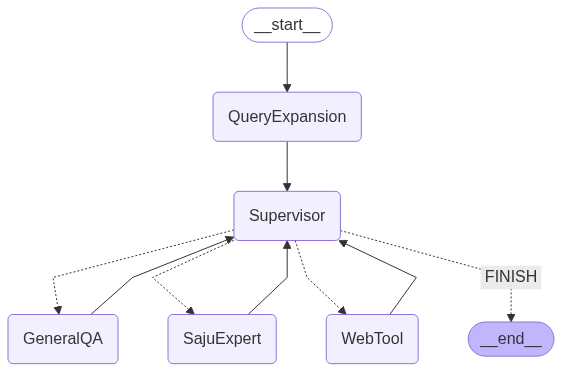

In [30]:
graph

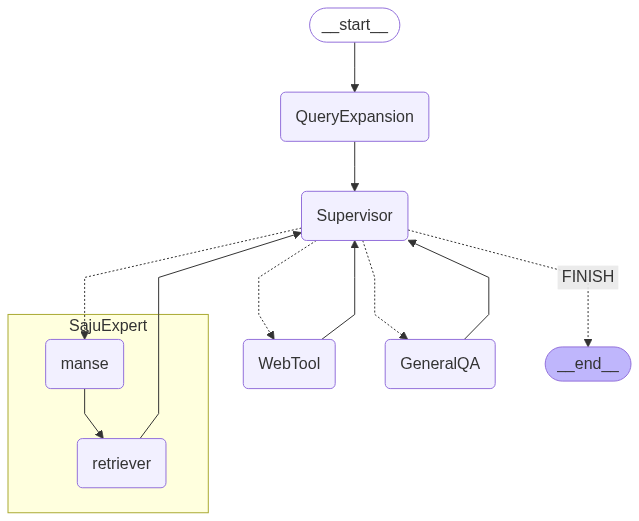

In [31]:
from IPython.display import display, Image
Image(graph.get_graph(xray=True).draw_mermaid_png())

In [24]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
#config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 3})

# 질문 입력

question = "1995년 3월 28일 남자, 12시 30분 출생 운세봐줘."

inputs = {
    "messages": [
        HumanMessage(
            content=question
            
        )
    ],
}

# 그래프 실행
stream_graph(graph, inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Could you provide a fortune reading for a male born on March 28, 1995, at 12:30 PM? I am interested in a detailed analysis of his Four Pillars of Destiny (Ba Zi) and how they may influence his personality, career prospects, and overall life path. Please include insights based on his birth chart analysis.1995년 3월 28일 남자, 12시 30분 출생 운세봐줘.
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
=== 사주팔자 ===
년주(年柱): 을해
월주(月柱): 기묘
일주(日柱): 무오
시주(時柱): 무오
일간(日干): 무
현재 나이: 30세 / 한국식 나이: 31세
기준 시점: 2025-06-22 09:59:45

=== 오행 강약 ===
목: 39점
화: 20점
토: 68점
금: 0점
수: 10점

=== 십신 분석 ===
년주: 천간:정관, 지지:편재(70%), 지지:편관(30%)
월주: 천간:겁재, 지지:정관(100%)
일주: 지지:정인(70%), 지지:겁재(30%)
시주: 지지:정인(70%), 지지:겁재(30%)

=== 대운 (정밀 계산) ===
5세: 무인 (2000년 ~ 2009년)
15세: 정축 (2010년 ~ 2019년)
25세: 병자 (2020년 

In [25]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
#config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 3})

# 질문 입력

question = "학업운 봐줘"

inputs = {
    "messages": [
        HumanMessage(
            content=question
            
        )
    ],
}

# 그래프 실행
stream_graph(graph, inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Could you please analyze my academic luck based on my Four Pillars of Destiny (Ba Zi)? I would like to understand how my birth chart influences my educational pursuits and what potential opportunities or challenges I may face in my studies.학업운 봐줘
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
1995년 3월 28일 12시 30분 출생 남성의 사주를 바탕으로 학업운을 분석해보면 다음과 같습니다.

1. 지식과 학업을 상징하는 정인과 식신 기운이 존재합니다. 년지 해(亥, 수)는 정인으로 지식과 보호를 의미하며, 시지 午(화)는 식신으로 창의력과 표현력을 나타냅니다. 이는 학업에 대한 관심과 능력이 있음을 보여줍니다.

2. 오행 중 수(水) 기운이 약간 있으나 금(金) 기운이 부족한 편입니다. 금은 학문과 지혜, 집중력을 상징하므로 금 기운 부족은 집중력이나 세밀한 학습에 다소 어려움이 있을 수 있음을 의미합니다. 따라서 학습 시 집중력 향상을 위한 환경 조성이나 보완이 필요합니다.

3. 토(土) 기운이 강해 현실적이고 신중한 성향이 강합니다. 이는 꾸준한 노력과 성실함으로 학업에 임할 수 있는 좋은 기질입니다.

4. 대운에서 병자(丙子) 대운이 진행 중이며, 화(火)와 수(水) 기운이 보강되어 학업에 긍정적인 영향을 미칩니다. 특히 2023~2025년은 화와 목 기운이 좋아 학업과 자기계발에 좋은 시기입니다.

5. 경쟁심과 창의

In [26]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
#config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 3})

# 질문 입력

question = "재물운봐줘"

inputs = {
    "messages": [
        HumanMessage(
            content=question
            
        )
    ],
}

# 그래프 실행
stream_graph(graph, inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Could you please analyze my financial luck based on my Four Pillars of Destiny (Ba Zi)? I would like to understand how my birth chart influences my wealth prospects and what specific elements or interactions in my chart may affect my financial situation.재물운봐줘
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
1995년 3월 28일 12시 30분 출생 남성의 사주를 바탕으로 재물운을 분석해보면 다음과 같습니다.

1. 재물을 상징하는 편재(乙, 을)가 년간에 위치해 있어 재물에 대한 관심과 능력이 있습니다. 편재는 자신의 노력과 능력으로 재물을 얻는 기운을 의미합니다.

2. 토(土) 기운이 강해 현실적이고 신중한 성향이 강하며, 이는 재물 관리에 있어서도 안정적이고 계획적인 태도를 나타냅니다. 무리한 투자보다는 꾸준한 저축과 계획적인 재테크에 유리합니다.

3. 금(金) 기운이 부족한 점은 재물 운용에 있어 결단력이나 추진력에서 다소 부족할 수 있음을 의미합니다. 따라서 중요한 재정 결정 시 신중한 판단과 주변의 조언을 구하는 것이 좋습니다.

4. 대운에서 병자(丙子) 대운이 진행 중이며, 화(火)와 수(水) 기운이 보강되어 재물운에 긍정적인 영향을 미칩니다. 특히 화는 재물을 불리는 에너지로 작용할 수 있어 현재 시기는 재물 증식에 좋은 시기입니다.

5. 경쟁심과 도전정신이 강해 새로운 재물 기회를 탐색하는 데 유리하지만

In [27]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
#config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 3})

# 질문 입력

question = "애정운 봐줘"

inputs = {
    "messages": [
        HumanMessage(
            content=question
            
        )
    ],
}

# 그래프 실행
stream_graph(graph, inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Could you please analyze my love fortune based on my Four Pillars of Destiny (Ba Zi)? I would like to understand how my birth chart influences my romantic relationships and what potential opportunities or challenges I might face in my love life.애정운 봐줘
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
=== 사주팔자 ===
년주(年柱): 을해
월주(月柱): 기묘
일주(日柱): 무오
시주(時柱): 무오
일간(日干): 무
현재 나이: 30세 / 한국식 나이: 31세
기준 시점: 2025-06-22 10:00:59

=== 오행 강약 ===
목: 39점
화: 20점
토: 68점
금: 0점
수: 10점

=== 십신 분석 ===
년주: 천간:정관, 지지:편재(70%), 지지:편관(30%)
월주: 천간:겁재, 지지:정관(100%)
일주: 지지:정인(70%), 지지:겁재(30%)
시주: 지지:정인(70%), 지지:겁재(30%)

=== 대운 (정밀 계산) ===
5세: 무인 (2000년 ~ 2009년)
15세: 정축 (2010년 ~ 2019년)
25세: 병자 (2020년 ~ 2029년)
35세: 을해 (2030년 ~ 2039년)
🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - 

In [28]:
--

SyntaxError: invalid syntax (3659366440.py, line 1)

In [32]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
#config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 3})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="1997년 09월 01일 여자, 11시 30분 출생 운세봐줘"
            
        )
    ],
}

# 그래프 실행
stream_graph(graph, inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Could you please provide a fortune reading for a female born on September 1, 1997, at 11:30 AM? I am interested in a detailed analysis of her Four Pillars of Destiny (Ba Zi) and how her birth chart influences her personality, career prospects, and overall life path.1997년 09월 01일 여자, 11시 30분 출생 운세봐줘
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
=== 사주팔자 ===
년주(年柱): 정축
월주(月柱): 무신
일주(日柱): 병오
시주(時柱): 계사
일간(日干): 병
현재 나이: 27세 / 한국식 나이: 29세
기준 시점: 2025-06-22 10:09:30

=== 오행 강약 ===
목: 0점
화: 59점
토: 38점
금: 11점
수: 28점

=== 십신 분석 ===
년주: 천간:겁재, 지지:상관(60%), 지지:정관(30%), 지지:정재(10%)
월주: 천간:식신, 지지:편재(60%), 지지:편관(30%), 지지:식신(10%)
일주: 지지:겁재(70%), 지지:상관(30%)
시주: 천간:정관, 지지:식신(30%), 지지:편재(10%)

=== 대운 (정밀 계산) ===
6세: 기유 (2003년 ~ 2012년)
16세: 경술 (2013년 ~ 2022년)
26세: 신해 (202

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 1047576 tokens. However, your messages resulted in 1180002 tokens (1179956 in the messages, 46 in the functions). Please reduce the length of the messages or functions.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

In [36]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
#config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 3})

question = "1995년 3월 28일 남자, 1997년 09월 01일 여자의 궁합운 운세봐줘"
# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content=question
            
        )
    ],
}

# 그래프 실행
stream_graph(graph, inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Could you please analyze the compatibility between a male born on March 28, 1995, and a female born on September 1, 1997, using their Four Pillars of Destiny (Ba Zi)? I am interested in understanding their birth chart analysis and how their elements interact, as well as any insights into their potential relationship dynamics and compatibility.1995년 3월 28일 남자, 1997년 09월 01일 여자의 궁합운 운세봐줘

RateLimitError: Error code: 429 - {'error': {'message': 'Request too large for gpt-4.1-mini-long-context in organization org-n8h6eTrPolQT4RTdz1CaZ4kB on tokens per min (TPM): Limit 1000000, Requested 7339794. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [38]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
#config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 3})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="대운과 세운, 조심해야 할것들 알려줘"
            
        )
    ],
}

# 그래프 실행
stream_graph(graph, inputs, config)



🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Could you provide insights on the major luck cycles (Da Yun) and annual luck cycles (Se Yun) in my Four Pillars of Destiny (Ba Zi) chart? Additionally, I would like to know what specific areas I should be cautious about during these cycles, based on my birth chart analysis.대운과 세운, 조심해야 할것들 알려줘
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요. 1997년 9월 1일 오전 11시 30분 출생 여성분의 대운과 세운, 그리고 주의사항에 대해 상세히 분석해 드리겠습니다.

---

## 1. 대운(大運) 분석

### 대운 시작 나이 및 방향

- 출생 월(음력 7월, 무신월) 기준으로 여성은 대운을 역행(뒤로) 시작합니다.
- 대운 시작 나이는 보통 8세 전후이며, 정확한 시작 시점은 음력 생월과 생일에 따라 다르지만 대략 7~8세부터 시작한다고 봅니다.

### 대운 목록 및 해석

| 나이 구간 | 대운  | 천간지지 | 오행 구성 | 해석 및 특징                          |
|-----------|--------|----------|-----------|-------------------------------------|
| 0~8       | -      | -        | -         | 출생부터 대운 시작 전, 성장기        |
| 8~18    

In [39]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
#config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 3})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="금전운알려줘"
            
        )
    ],
}

# 그래프 실행
stream_graph(graph, inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Could you provide an analysis of my financial luck based on my Four Pillars of Destiny (Ba Zi)? I am particularly interested in understanding how my birth chart influences my financial opportunities and challenges.금전운알려줘
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요. 1997년 9월 1일 오전 11시 30분 출생 여성분의 금전운에 대해 사주 원리와 오행, 십신 분석을 바탕으로 상세히 안내해 드리겠습니다.

---

## 1. 사주 구성 및 오행 요약

| 구분 | 천간 | 지지 | 오행 |
|-------|-------|-------|-------|
| 연주  | 丁     | 丑     | 화, 토 |
| 월주  | 戊     | 申     | 토, 금 |
| 일주  | 丙     | 午     | 화, 화 |
| 시주  | 癸     | 巳     | 수, 화 |

- 화(火) 4점, 토(土) 2점, 금(金) 1점, 수(水) 1점, 목(木) 0점
- 화가 매우 강하고, 토가 그 다음이며 금과 수는 약간, 목은 부족한 상태입니다.

---

## 2. 금전운과 관련된 십신 및 오행 해석

### 1) 금전운을 나타내는 십신

- 금전운은 일간(일주 천간 丙火) 기준으로 재성(財星)과 편재(偏財), 정재(正財)로 판단합니다.
- 火(일간 丙) 기준으로:
  - 재성(正財): 토(土) → 戊, 己, 丑, 辰, 戌, 未
  - 편재(偏財): 토(

In [40]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
#config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 1})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="1995년 3월 28일 남자, 12시 30분 출생 운세봐줘"
        )
    ],
}

# 그래프 실행
stream_graph(graph, inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Could you provide a fortune reading for a male born on March 28, 1995, at 12:30 PM? I am interested in a detailed analysis of his Four Pillars of Destiny (Ba Zi) and how they may influence his personality, career prospects, and overall life path. Please include insights based on his birth chart analysis and any significant elements or interactions present in his chart.1995년 3월 28일 남자, 12시 30분 출생 운세봐줘
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
=== 사주팔자 ===
년주(年柱): 을해
월주(月柱): 기묘
일주(日柱): 무오
시주(時柱): 무오
일간(日干): 무

=== 오행 강약 ===
목: 39점
화: 20점
토: 68점
금: 0점
수: 10점

=== 십신 분석 ===
년주: 천간:정관, 지지:편재(70%), 지지:편관(30%)
월주: 천간:겁재, 지지:정관(100%)
일주: 지지:정인(70%), 지지:겁재(30%)
시주: 지지:정인(70%), 지지:겁재(30%)

=== 대운 (정밀 계산) ===
5세: 무인 (2000년 ~ 2009년)
15세: 정축 (2010년 ~ 2019년)
25

In [41]:
# 추가질문 -> 바로 retriever tool로 들어갔다

In [42]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
#config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 1})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="대운과 세운분석 자세히 해줘"
        )
    ],
}

# 그래프 실행
stream_graph(graph, inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Could you provide a detailed analysis of my Daewoon (major luck cycle) and Sewoon (annual luck cycle) in relation to my Four Pillars of Destiny (Ba Zi)? I am particularly interested in understanding how these cycles influence my current life circumstances and future prospects based on my birth chart.대운과 세운분석 자세히 해줘
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요. 1995년 3월 28일 12시 30분 출생 남성분의 대운과 세운(연운) 분석을 자세히 진행하겠습니다.

---

## 1. 대운(大運) 분석

### 대운 시작 시기 산출

- 출생 월: 3월 (양력)
- 출생 시: 午시 (11:30~13:30)
- 남성은 출생 월의 절기 기준으로 앞으로 대운이 진행됨
- 1995년 3월 28일은 춘분(3월 21일) 이후 출생이므로 대운은 출생 후 약 1년 5개월 후부터 시작 (대략 1세 5개월부터)

### 대운별 10년 주기 및 오행 특성

| 나이 구간 | 대운  | 천간지지 | 오행 및 특징                      |
|-----------|--------|-----------|---------------------------------|
| 1~10세    | 기미(己未) | 토(土) 중심 | 토 기운 강화, 안정과 성장 기반 마련 |
| 11~20세  

In [43]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
#config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 1})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="난 미래에 대한 대운과 세운분석이 궁금해"
        )
    ],
}

# 그래프 실행
stream_graph(graph, inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
I am curious about the analysis of my luck cycles (Da Yun) and annual luck (Se Yun) in relation to my Four Pillars of Destiny (Ba Zi). Specifically, I would like to understand how these cycles will influence my future and what insights can be drawn from my birth chart analysis. Could you provide guidance on how to interpret these aspects in my life?난 미래에 대한 대운과 세운분석이 궁금해
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요. 1995년 3월 28일 12시 30분 출생 남성분의 미래 대운과 세운(연운) 분석을 자세히 안내해 드리겠습니다.

---

## 1. 미래 대운(大運) 분석

### 대운 시작 시기 및 진행 방향

- 출생 월(3월) 기준으로 남성은 앞으로 대운이 진행됩니다.
- 대운 시작은 출생 후 약 1년 5개월부터 시작하여 10년 단위로 변화합니다.

### 미래 대운 목록 및 특징

| 나이 구간 | 대운  | 천간지지 | 오행 및 특징                      |
|-----------|--------|-----------|---------------------------------|
| 26~35세   | 임술(壬戌) | 수(土) 중심 | 감성, 지혜, 유연성 보완, 대인관계 개선 |
| 36~45세  

In [33]:
# Enhanced Retriever with Query Expansion 테스트
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 2})

# 한글 사주 질문으로 테스트 (Query Expansion이 작동할 질문)
inputs = {
    "messages": [
        HumanMessage(
            content="정관이 뭐야? 상세히 설명해줘"
        )
    ],
}


# 그래프 실행
stream_graph(graph, inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
What is the concept of "正官" (Zheng Guan) in the context of the Four Pillars of Destiny, also known as Ba Zi? Please provide a detailed explanation of its significance and how it influences a person's birth chart analysis, particularly in relation to one's career, relationships, and overall life path.정관이 뭐야? 상세히 설명해줘
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
"정관"이라는 단어는 여러 분야에서 다르게 사용될 수 있는데, 여기서는 대표적으로 두 가지 의미를 상세히 설명해 드리겠습니다.

1. 사주명리학에서의 정관
사주명리학(四柱命理學)에서 "정관(正官)"은 십신(十神) 중 하나로, 자신의 일간(자신을 나타내는 천간) 기준으로 정해지는 오행 관계 중 하나입니다. 정관은 주로 '관직, 규율, 법, 권위, 책임' 등을 상징하며, 사회적 지위나 명예, 직업적인 면에서 중요한 역할을 합니다.

- 정관의 의미: 정관은 '바른 관직'이라는 뜻으로, 규범과 질서를 상징합니다. 정관이 강하면 그 사람은 책임감이 강하고, 법과 규칙을 잘 따르며, 사회적으로 신뢰받는 위치에 있을 가능성이 큽니다.
- 정관의 역할: 정관은 일간이 남자일 경우 여성(아내)을, 여자일 경우 남성(남편)을 나타내기도 합니다.
- 정관의 오행 관계: 정관은 일간을 생하는 오행(생하는 오행이 정관)과의 관계로 정의됩니다.

In [45]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="사주의 개념에 대해서 알려줘"
        )
    ],
}

# 그래프 실행
invoke_graph(graph, inputs, config)


🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

사주의 개념에 대해서 알려줘

🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
WebTool

🔄 Node: agent in [WebTool] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

사주(四柱)는 한국과 중국 등 동아시아에서 전통적으로 사용되는 운명학의 한 분야로, 사람의 태어난 연, 월, 일, 시를 기준으로 하여 그 사람의 운명과 성격, 미래의 길흉화복을 해석하는 체계입니다. 

사주는 '네 기둥'이라는 뜻으로, 태어난 연도, 월, 일, 시를 각각 한 기둥으로 보고, 이 네 기둥을 합쳐서 개인의 운명을 분석합니다. 각 기둥은 천간(10간)과 지지(12지)로 구성되어 있으며, 이를 통해 오행(목, 화, 토, 금, 수)의 상호작용과 음양의 조화를 살펴봅니다.

사주를 통해 개인의 성격, 건강, 직업, 인간관계, 재물운, 결혼운 등 다양한 인생의 측면을 예측하고 조언하는 데 활용합니다. 또한, 사주는 운세뿐 아니라 자신과 주변 환경과의 조화를 이해하고, 더 나은 삶을 위한 방향을 찾는 데 도움을 주는 도구로 여겨집니다.

필요하면 사주의 구성 요소나 오행, 천간과 지지에 대해서도 자세히 설명해 드릴 수 있습니다.

🔄 Node: WebTool 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ H

In [46]:
# GeneralQA 도구 테스트 - 일반 질문
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, stream_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 2})

# 일반 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="파이썬에서 딕셔너리와 리스트의 차이점을 알려주세요"
        )
    ],
}

# 그래프 실행
stream_graph(graph, inputs, config)



🔄 Node: QueryExpansion 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Could you explain the differences between a dictionary and a list in Python, particularly in the context of data structures used for organizing information? Additionally, I am interested in understanding how these concepts might relate to the analysis of a birth chart in the Four Pillars of Destiny (Ba Zi), where different elements and their relationships can be represented in various formats.파이썬에서 딕셔너리와 리스트의 차이점을 알려주세요
🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: agent 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
## 파이썬 딕셔너리와 리스트의 차이점

파이썬에서 딕셔너리(dictionary)와 리스트(list)는 모두 여러 개의 값을 저장하는 데 사용되는 자료구조이지만, 몇 가지 중요한 차이점이 있습니다.

**1. 데이터 접근 방식:**

*   **리스트 (List):**
    *   **순서 기반 접근:** 리스트는 요소의 순서가 중요하며, 각 요소는 **인덱스(index)**를 통해 접근합니다. 인덱스는 0부터 시작하는 정수입니다.
    *   예시: `my_list[0]`은 리스트의 첫 번째 요소를 가져옵니다.